# Лабораторная работа №1
## ----------------------------------------------------------------------------------------------------------------------------------
## Задание:
1 . Провести классификацию найденного датасета, методами линеной и логистической регрессий . В формате Markdown написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.

## Решение:
#### Подключаем библеотеки


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

### Загружаю данные и вывод датасет


In [2]:
Dataset = pd.read_csv('cybersecurity_attacks.csv') 
label_encoder = LabelEncoder()
Dataset['Attack Type Encoded'] = label_encoder.fit_transform(Dataset['Attack Type'])
non_numeric_columns = Dataset.select_dtypes(exclude=['number']).columns.tolist()
Dataset = Dataset.drop(columns=non_numeric_columns)
# Заполнение пустых значений средними значениями
columns_to_fill = ['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores']
for column in columns_to_fill:
    mean_value = Dataset[column].mean()
    Dataset[column].fillna(mean_value, inplace=True)
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Source Port          40000 non-null  int64  
 1   Destination Port     40000 non-null  int64  
 2   Packet Length        40000 non-null  int64  
 3   Anomaly Scores       40000 non-null  float64
 4   Attack Type Encoded  40000 non-null  int32  
dtypes: float64(1), int32(1), int64(3)
memory usage: 1.4 MB


### Преобразую данные и разделяю на признаки

In [3]:
X = Dataset.drop(columns=['Attack Type Encoded'])  
y = Dataset['Attack Type Encoded']


### Ищем лучший параметр

In [4]:
X_train, X_test, y_train, y_test = train_test_split(Dataset.drop('Attack Type Encoded', axis=1), Dataset['Attack Type Encoded'], test_size=0.4, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

under_sampler = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

print(pd.Series(y_resampled).value_counts())
print(y_test.unique())
# Создание модели
linear_model = LinearRegression()

# Подготовка параметров для GridSearchCV
linear_params = {'fit_intercept': [True, False]}

# Инициализация GridSearchCV
linear_grid = GridSearchCV(linear_model, linear_params, cv=5)

# Обучение модели
linear_grid.fit(X_resampled, y_resampled)

# Вывод результатов
print("Лучшие параметры для линейной регрессии:", linear_grid.best_params_)

0    7849
1    7849
2    7849
Name: Attack Type Encoded, dtype: int64
[2 0 1]
Лучшие параметры для линейной регрессии: {'fit_intercept': True}


### Оценка линейной регресии

MAE:  0.663106349697707
MSE:  0.6615384345210228
R^2:  -6.27319926520542e-05


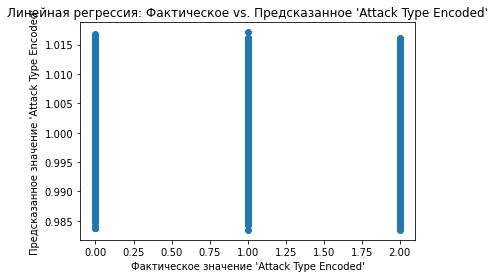

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      5306
           1       0.34      1.00      0.51      5416
           2       1.00      0.00      0.00      5278

    accuracy                           0.34     16000
   macro avg       0.78      0.33      0.17     16000
weighted avg       0.78      0.34      0.17     16000



In [5]:
# Предсказание на тестовых данных с лучшими параметрами
linear_predictions = linear_grid.predict(X_test)

# Оценка качества модели регрессии
mae = mean_absolute_error(y_test, linear_predictions)
mse = mean_squared_error(y_test, linear_predictions)
r2 = r2_score(y_test, linear_predictions)

print("MAE: ", mae)
print("MSE: ", mse)
print("R^2: ", r2)

# Визуа`изация результатов регрессии
plt.scatter(y_test, linear_predictions)
plt.xlabel("Фактическое значение 'Attack Type Encoded'")
plt.ylabel("Предсказанное значение 'Attack Type Encoded'")
plt.title("Линейная регрессия: Фактическое vs. Предсказанное 'Attack Type Encoded'")
plt.show()

# Округление предсказанных значений до целых чисел (поскольку это классы)
rounded_predictions = [round(pred) for pred in linear_predictions]
# Вывод отчета классификации
print(classification_report(y_test, rounded_predictions, zero_division=1))


### Класификация с использованием логической регресии и построение графика


Лучшие параметры для логистической регрессии: {'C': 0.001, 'penalty': 'l2'}
Отчет о классификации для логистической регрессии:
               precision    recall  f1-score   support

           0       0.33      0.67      0.44      5306
           1       0.32      0.10      0.15      5416
           2       0.33      0.22      0.26      5278

    accuracy                           0.33     16000
   macro avg       0.33      0.33      0.28     16000
weighted avg       0.33      0.33      0.28     16000



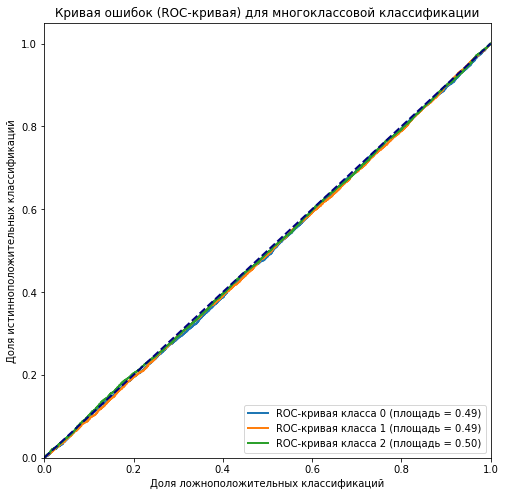

In [6]:
X = Dataset.drop('Attack Type Encoded', axis=1) 
y = Dataset['Attack Type Encoded']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

logistic_model = LogisticRegression(multi_class='auto', solver='liblinear', max_iter=1000)

logistic_params = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}

logistic_grid = GridSearchCV(logistic_model, logistic_params, cv=5)
logistic_grid.fit(X_train, y_train)

print("Лучшие параметры для логистической регрессии:", logistic_grid.best_params_)

best_logistic_model = LogisticRegression(
    multi_class='auto',
    solver='liblinear',
    max_iter=1000,
    C=logistic_grid.best_params_['C'],
    penalty=logistic_grid.best_params_['penalty']
)

best_logistic_model.fit(X_train, y_train)

logistic_predictions = best_logistic_model.predict(X_test)
logistic_classification_report = classification_report(y_test, logistic_predictions)
print("Отчет о классификации для логистической регрессии:\n", logistic_classification_report)

logistic_probabilities = best_logistic_model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(y_test == i, logistic_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 8))
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC-кривая класса {0} (площадь = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Доля ложноположительных классификаций')
plt.ylabel('Доля истинноположительных классификаций')
plt.title('Кривая ошибок (ROC-кривая) для многоклассовой классификации')
plt.legend(loc='lower right')
plt.show()

